# Reboot - Improving Estimated Delivery Time

In this section we build a predictive model to improve Olist ETA prediction of orders `wait_time`

## Load and check `orders` dataset

In [1]:
# Load all orders from our training_data, including those non-delivered

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#import data
from olist.order import Order

In [8]:
orders = Order().get_training_data(is_delivered=True)

In [9]:
orders.head(2)

,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status,dim_is_five_star,dim_is_one_star,review_score,number_of_products,number_of_sellers,price,freight_value,distance_seller_customer
0,e481f51cbdc54678b7cc49136f2d6af7,8.436574,15.544063,0.0,delivered,0,0,4,1,1,29.99,8.72,18.063837
1,53cdb2fc8bc7dce0b6741e2150273451,13.782037,19.137766,0.0,delivered,0,0,4,1,1,118.70,22.76,856.292580


In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96531 entries, 0 to 98726
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   order_id                  96531 non-null  object 
 1   wait_time                 96531 non-null  float64
 2   expected_wait_time        96531 non-null  float64
 3   delay_vs_expected         96531 non-null  float64
 4   order_status              96531 non-null  object 
 5   dim_is_five_star          96531 non-null  int64  
 6   dim_is_one_star           96531 non-null  int64  
 7   review_score              96531 non-null  int64  
 8   number_of_products        96531 non-null  int64  
 9   number_of_sellers         96531 non-null  int64  
 10  price                     96531 non-null  float64
 11  freight_value             96531 non-null  float64
 12  distance_seller_customer  96531 non-null  float64
dtypes: float64(6), int64(5), object(2)
memory usage: 10.3+ MB


## 1 - Baseline Model - Olist’s current ETA model

❓ What's the baseline we want to optimize?

The delta between Olist' `expected_wait_time` and the real `wait_time`

Plot their respective histogram, median difference and RMSE

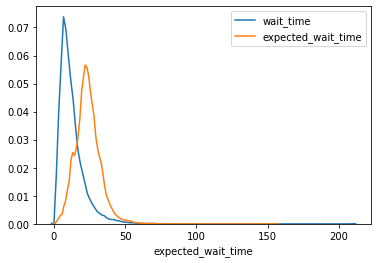

In [10]:
# Plot distribution
sns.distplot(orders['wait_time'], hist=False, label='wait_time')
sns.distplot(orders['expected_wait_time'], hist=False, label='expected_wait_time')

In [184]:
# Compute median
orders[['wait_time', 'expected_wait_time']].median()

wait_time             10.215972
expected_wait_time    23.232187
dtype: float64

In [11]:
# Compute baseline RMSE (i.e 𝛔(error_from_olist))

error_from_olist = orders['expected_wait_time'] - orders['wait_time']
error_from_olist

0         7.107488
1         5.355729
2        17.245498
3        12.980069
4         9.238171
           ...    
96528    10.369433
96529     1.265324
96530     5.524803
96531    20.018819
96532    17.452431
Length: 96525, dtype: float64

In [12]:
((error_from_olist**2).mean())**0.5

15.13096685744435

## 2 - OLS multivariate model

Create an OLS model using the `statsmodel.api.OLS` method (not the `statsmodel.formula.api.ols`) this time

In [13]:
import statsmodels.api as sm

### prepare dataset of features X

In [14]:
orders.columns

Index(['order_id', 'wait_time', 'expected_wait_time', 'delay_vs_expected',
       'order_status', 'dim_is_five_star', 'dim_is_one_star', 'review_score',
       'number_of_products', 'number_of_sellers', 'price', 'freight_value',
       'distance_seller_customer'],
      dtype='object')

In [15]:
# Create target variable y (Serie) and feature X (DataFrame) without data leaks!
y = orders["wait_time"].copy()

X = orders[[
        "number_of_products",
        "number_of_sellers",
        "price",
        "freight_value",
        "distance_seller_customer",
    ]].copy()
X

,number_of_products,number_of_sellers,price,freight_value,distance_seller_customer
0,1,1,29.99,8.72,18.063837
1,1,1,118.70,22.76,856.292580
2,1,1,159.90,19.22,514.130333
3,1,1,45.00,27.20,1822.800366
4,1,1,19.90,8.72,30.174037
...,...,...,...,...,...
96528,1,1,72.00,13.08,69.481037
96529,1,1,174.90,20.10,474.098245
96530,1,1,205.99,65.02,968.051192
96531,2,1,359.98,81.18,370.146853


In [189]:
X.columns

Index(['number_of_products', 'number_of_sellers', 'price', 'freight_value',
       'distance_seller_customer'],
      dtype='object')

In [16]:
# standardize (z-normalize) each features of X to compare coefficients

for f in X.columns:
    mu = X[f].mean()
    sigma = X[f].std()
    X[f] = X[f].map(lambda x: (x - mu) / sigma)

In [17]:
X

,number_of_products,number_of_sellers,price,freight_value,distance_seller_customer
0,-0.264004,-0.112813,-0.511860,-0.651997,-0.979467
1,-0.264004,-0.112813,-0.087278,-0.000604,0.428808
2,-0.264004,-0.112813,0.109912,-0.164844,-0.146045
3,-0.264004,-0.112813,-0.440019,0.205392,2.052600
4,-0.264004,-0.112813,-0.560153,-0.651997,-0.959121
...,...,...,...,...,...
96528,-0.264004,-0.112813,-0.310793,-0.449712,-0.893083
96529,-0.264004,-0.112813,0.181705,-0.124016,-0.213301
96530,-0.264004,-0.112813,0.330507,1.960071,0.616570
96531,1.586072,-0.112813,1.067531,2.709822,-0.387946


In [5]:
# Add a constant to your model

In [18]:
X['constant'] = 1
X

,number_of_products,number_of_sellers,price,freight_value,distance_seller_customer,constant
0,-0.264004,-0.112813,-0.511860,-0.651997,-0.979467,1
1,-0.264004,-0.112813,-0.087278,-0.000604,0.428808,1
2,-0.264004,-0.112813,0.109912,-0.164844,-0.146045,1
3,-0.264004,-0.112813,-0.440019,0.205392,2.052600,1
4,-0.264004,-0.112813,-0.560153,-0.651997,-0.959121,1
...,...,...,...,...,...,...
96528,-0.264004,-0.112813,-0.310793,-0.449712,-0.893083,1
96529,-0.264004,-0.112813,0.181705,-0.124016,-0.213301,1
96530,-0.264004,-0.112813,0.330507,1.960071,0.616570,1
96531,1.586072,-0.112813,1.067531,2.709822,-0.387946,1


### Run OLS with statsmodels

In [19]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [20]:
model = sm.OLS(y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              wait_time   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     3666.
Date:                Sat, 11 Jul 2020   Prob (F-statistic):               0.00
Time:                        13:34:38   Log-Likelihood:            -3.4629e+05
No. Observations:               96525   AIC:                         6.926e+05
Df Residuals:                   96519   BIC:                         6.926e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
number_of_products          -0.3148      0.033     -9.552      0.000      -0.379      -0.250
number_of_sellers           -0.3607      0.029    -12.275      0.000      -0.418      -0.303
price                        0.0474      0.031      1.531      0.126      -0.013       0.108
freight_value                0.6506      0.036     17.892      0.000       0.579       0.722
distance_seller_customer     3.5358      0.030    117.020      0.000       3.477       3.595
constant                    12.5553      0.028    445.983      0.000      12.500      12.610
==============================================================================
Omnibus:                    93067.183   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         10695196.220
Skew:                           4.395   Prob(JB):                         0.00
Kurtosis:                      53.813   Cond. No.                         2.18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [129]:
# Check prediction distributions

In [21]:
y_pred = model.predict(X)
y_true = orders['wait_time']
y_expected_olist = orders['expected_wait_time']

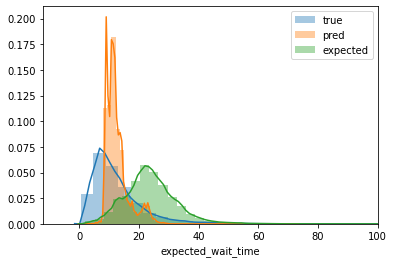

In [22]:
sns.distplot(y_true, label = 'true')
sns.distplot(y_pred, label = 'pred')
sns.distplot(y_expected_olist, label = 'expected')
plt.xlim(xmax=100)
plt.legend()

In [23]:
# Compute RMSE (i.e 𝛔(residuals))
residuals = y_true - y_pred
((1/len(residuals))*residuals.map(lambda x: x**2).sum())**0.5

8.746087535851

In [24]:
# Visualize analyse coefficients with  partial regression plots

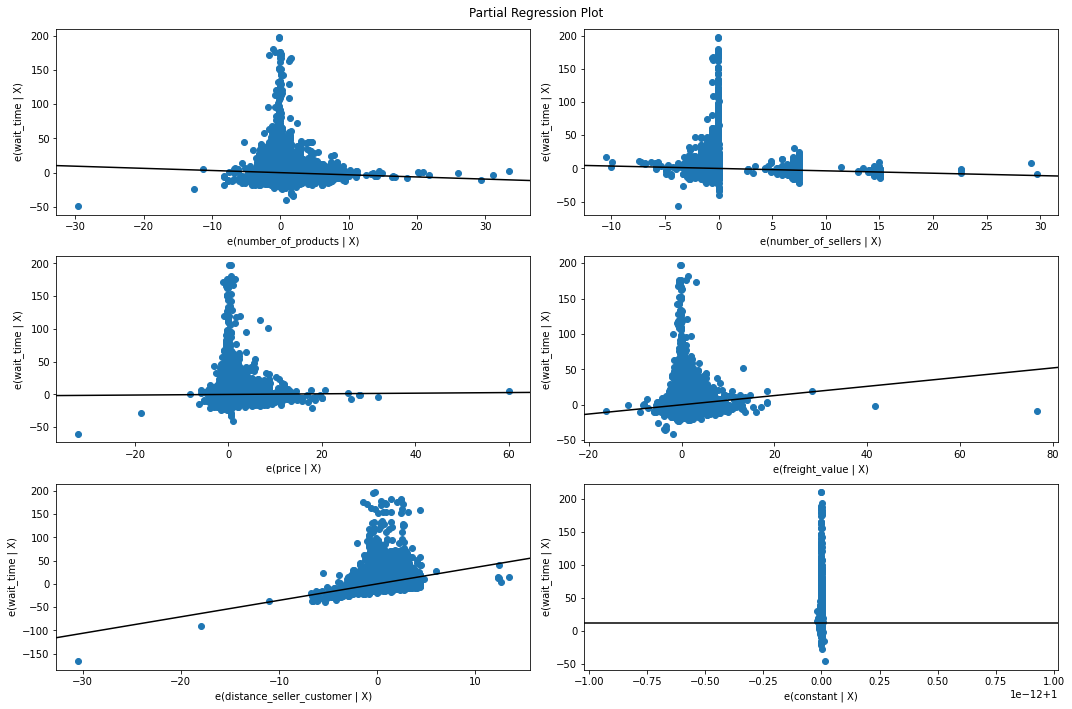

In [25]:
fig = plt.figure(figsize=(15,10))
sm.graphics.plot_partregress_grid(model, fig=fig)
plt.show()

## Check inferential conditions

❓ Check you ressiduals. Are they normally distributed?

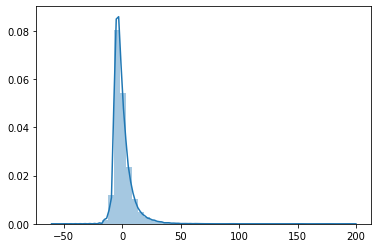

In [28]:
sns.distplot(residuals)

❓A more precise way to visualize normality is the [QQplot](https://www.statsmodels.org/stable/generated/statsmodels.graphics.gofplots.qqplot.html). 
Plot the qqplot of your residual below, and make sure to understand the link with the histogram above.

Interpreting QQplots ([source](https://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot))
- dots are arranged on `y-axis` in ascending order of values (y-axis = residual values)
- dots are spaced on `x-axis` proportionally to a "normal distribution"

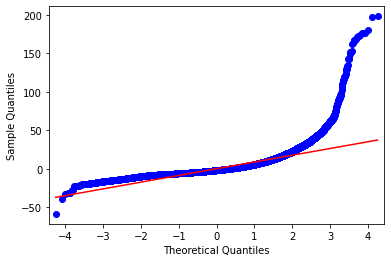

In [30]:
sm.qqplot(residuals, line='s');

❓ Check residuals vs. fitted to see if we can detect any non-random pattern

(0.0, 50.0)

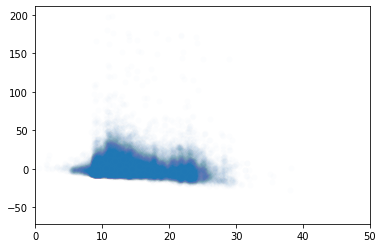

In [50]:
sns.scatterplot(y_pred, residuals, alpha=0.01)
plt.xlim(xmin=0, xmax=50)

## Can we add more Features? (Optional)

We add here additional features from the product details (size, category etc..)

### Add products details associated with each order (sum of product sizes, sum of weights etc...)

In [139]:
from olist.data import Olist
data = Olist().get_data()
products = data['olist_products_dataset']
order_items = data['olist_order_items_dataset']

In [146]:
order_items_products = (
    order_items.groupby(["order_id", "product_id"], as_index=False)
    .agg({"order_item_id": "count"})
    .rename(columns={"order_item_id": "order_item_count"})
    .merge(products.drop(["product_category_name"], axis=1), on="product_id")
)
order_items_products

,order_id,product_id,order_item_count,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,1,58.0,598.0,4.0,650.0,28.0,9.0,14.0
1,130898c0987d1801452a8ed92a670612,4244733e06e7ecb4970a6e2683c13e61,1,58.0,598.0,4.0,650.0,28.0,9.0,14.0
2,532ed5e14e24ae1f0d735b91524b98b9,4244733e06e7ecb4970a6e2683c13e61,1,58.0,598.0,4.0,650.0,28.0,9.0,14.0
3,6f8c31653edb8c83e1a739408b5ff750,4244733e06e7ecb4970a6e2683c13e61,1,58.0,598.0,4.0,650.0,28.0,9.0,14.0
4,7d19f4ef4d04461989632411b7e588b9,4244733e06e7ecb4970a6e2683c13e61,1,58.0,598.0,4.0,650.0,28.0,9.0,14.0
...,...,...,...,...,...,...,...,...,...,...
102420,ffebd80e3291e811c308365936897efd,4cc4d02efc8f249c13355147fb44e34d,1,37.0,653.0,1.0,6700.0,35.0,12.0,22.0
102421,ffee31fb4b5e35c9123608015637c495,b10ecf8e33aaaea419a9fa860ea80fb5,1,30.0,308.0,1.0,2300.0,37.0,30.0,20.0
102422,fff7c4452f050315db1b3f24d9df5fcd,dd469c03ad67e201bc2179ef077dcd48,1,33.0,658.0,3.0,400.0,19.0,9.0,15.0
102423,fffa82886406ccf10c7b4e35c4ff2788,bbe7651fef80287a816ead73f065fc4b,1,32.0,280.0,2.0,2700.0,60.0,15.0,15.0


In [147]:
order_items_products.nunique()

order_id                      98666
product_id                    32951
order_item_count                 16
product_name_lenght              66
product_description_lenght     2960
product_photos_qty               19
product_weight_g               2204
product_length_cm                99
product_height_cm               102
product_width_cm                 95
dtype: int64

In [148]:
order_items_features = order_items_products.groupby("order_id", as_index=False).agg(
    {
        "product_weight_g": "sum",
        "product_length_cm": "max",
        "product_height_cm": "max",
        "product_width_cm": "max",
    }).rename(columns={
        "product_weight_g": "product_weight_g_sum",
        "product_length_cm": "product_length_cm_max",
        "product_height_cm": "product_height_cm_max",
        "product_width_cm": "product_width_cm_max",
    })
order_items_features

,order_id,product_weight_g_sum,product_length_cm_max,product_height_cm_max,product_width_cm_max
0,00010242fe8c5a6d1ba2dd792cb16214,650.0,28.0,9.0,14.0
1,00018f77f2f0320c557190d7a144bdd3,30000.0,50.0,30.0,40.0
2,000229ec398224ef6ca0657da4fc703e,3050.0,33.0,13.0,33.0
3,00024acbcdf0a6daa1e931b038114c75,200.0,16.0,10.0,15.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,3750.0,35.0,40.0,30.0
...,...,...,...,...,...
98661,fffc94f6ce00a00581880bf54a75a037,10150.0,89.0,15.0,40.0
98662,fffcd46ef2263f404302a634eb57f7eb,8950.0,45.0,26.0,38.0
98663,fffce4705a9662cd70adb13d4a31832d,967.0,21.0,24.0,19.0
98664,fffe18544ffabc95dfada21779c9644f,100.0,20.0,20.0,20.0


In [158]:
orders2 = orders.merge(order_items_features, on="order_id", how="left").dropna()

### Run new OLS

In [159]:
orders2

,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status,dim_is_five_star,dim_is_one_star,review_score,number_of_products,number_of_sellers,price,freight_value,distance_seller_customer,product_weight_g_sum,product_length_cm_max,product_height_cm_max,product_width_cm_max
0,e481f51cbdc54678b7cc49136f2d6af7,8.436574,15.544063,0.0,delivered,0,0,4,1,1,29.99,8.72,18.063837,500.0,19.0,8.0,13.0
1,53cdb2fc8bc7dce0b6741e2150273451,13.782037,19.137766,0.0,delivered,0,0,4,1,1,118.70,22.76,856.292580,400.0,19.0,13.0,19.0
2,47770eb9100c2d0c44946d9cf07ec65d,9.394213,26.639711,0.0,delivered,1,0,5,1,1,159.90,19.22,514.130333,420.0,24.0,19.0,21.0
3,949d5b44dbf5de918fe9c16f97b45f8a,13.208750,26.188819,0.0,delivered,1,0,5,1,1,45.00,27.20,1822.800366,450.0,30.0,10.0,20.0
4,ad21c59c0840e6cb83a9ceb5573f8159,2.873877,12.112049,0.0,delivered,1,0,5,1,1,19.90,8.72,30.174037,250.0,51.0,15.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96520,9c5dedf39a927c1b2549525ed64a053c,8.218009,18.587442,0.0,delivered,1,0,5,1,1,72.00,13.08,69.481037,1175.0,22.0,13.0,18.0
96521,63943bddc261676b46f01ca7ac2f7bd8,22.193727,23.459051,0.0,delivered,0,0,4,1,1,174.90,20.10,474.098245,4950.0,40.0,10.0,40.0
96522,83c1379a015df1e13d02aae0204711ab,24.859421,30.384225,0.0,delivered,1,0,5,1,1,205.99,65.02,968.051192,13300.0,32.0,90.0,22.0
96523,11c177c8e97725db2631073c19f07b62,17.086424,37.105243,0.0,delivered,0,0,2,2,1,359.98,81.18,370.146853,6550.0,20.0,20.0,20.0


In [175]:
X2 = orders_2[[
        "number_of_products",
        "number_of_sellers",
        "price",
        "freight_value",
        "distance_seller_customer",
        "product_weight_g_sum",
        "product_length_cm_max",
        "product_height_cm_max",
        "product_width_cm_max"]].copy()
y2 = orders_2["wait_time"].copy()

In [176]:
# standardize (z-normalize) each features of X to compare coefficients

for f in X2.columns:
    mu = X2[f].mean()
    sigma = X2[f].std()
    X2[f] = X2[f].map(lambda x: (x - mu) / sigma)

In [177]:
X2['constant'] = 1

In [178]:
model2 = sm.OLS(y2, X2).fit()

In [179]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              wait_time   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     2106.
Date:                Wed, 20 May 2020   Prob (F-statistic):               0.00
Time:                        14:20:08   Log-Likelihood:            -3.4597e+05
No. Observations:               96509   AIC:                         6.920e+05
Df Residuals:                   96499   BIC:                         6.920e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
number_of_products          -0.1032      0.034     -2.991      0.003      -0.171      -0.036
number_of_sellers           -0.4006      0.029    -13.639      0.000      -0.458      -0.343
price                       -0.0328      0.031     -1.053      0.293      -0.094       0.028
freight_value                0.1399      0.044      3.177      0.001       0.054       0.226
distance_seller_customer     3.7097      0.031    118.330      0.000       3.648       3.771
product_weight_g_sum         0.4481      0.045      9.973      0.000       0.360       0.536
product_length_cm_max        0.3946      0.035     11.283      0.000       0.326       0.463
product_height_cm_max        0.2085      0.035      6.019      0.000       0.141       0.276
product_width_cm_max        -0.0650      0.036     -1.810      0.070      -0.135       0.005
constant                    12.5553      0.028    447.155      0.000      12.500      12.610
==============================================================================
Omnibus:                    93162.863   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         10764031.420
Skew:                           4.403   Prob(JB):                         0.00
Kurtosis:                      53.983   Cond. No.                         3.56
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""